In [1]:
from pathlib import Path
import pickle

import pandas as pd
import numpy as np
import inspect

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.utils.config import Config
import neuralhydrology.modelzoo
from neuralhydrology.nh_run import start_run, eval_run, finetune

In [2]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU or MacOS with Metal support
if torch.cuda.is_available() or torch.backends.mps.is_available():
    start_run(config_file=Path("1_basin.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("1_basin.yml"), gpu=-1)

2025-06-04 04:10:47,602: Logging to d:\github\neuralhydrology\neuralhydrology\own\MtslstmCMAL\runs\test_run_0406_041047\output.log initialized.
2025-06-04 04:10:47,603: ### Folder structure created at d:\github\neuralhydrology\neuralhydrology\own\MtslstmCMAL\runs\test_run_0406_041047
2025-06-04 04:10:47,603: ### Run configurations for test_run
2025-06-04 04:10:47,604: experiment_name: test_run
2025-06-04 04:10:47,604: use_frequencies: ['1h', '1D']
2025-06-04 04:10:47,605: train_basin_file: 1_basin.txt
2025-06-04 04:10:47,606: validation_basin_file: 1_basin.txt
2025-06-04 04:10:47,606: test_basin_file: 1_basin.txt
2025-06-04 04:10:47,607: train_start_date: 1999-10-01 00:00:00
2025-06-04 04:10:47,608: train_end_date: 2008-09-30 00:00:00
2025-06-04 04:10:47,608: validation_start_date: 1996-10-01 00:00:00
2025-06-04 04:10:47,609: validation_end_date: 1999-09-30 00:00:00
2025-06-04 04:10:47,610: test_start_date: 1989-10-01 00:00:00
2025-06-04 04:10:47,610: test_end_date: 1996-09-30 00:00:00

In [3]:
run_dir = Path("runs/test_run_0406_041047")
eval_run(run_dir=run_dir, period="test")

2025-06-04 04:30:34,293: No specific hidden size for frequencies are specified. Same hidden size is used for all.
2025-06-04 04:30:34,302: Using the model weights from runs\test_run_0406_041047\model_epoch050.pt
# Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]2025-06-04 04:30:34,320: ## Warning: Hourly nldas_hourly NetCDF file not found. Falling back to slower csv files.
DEBUG: Processing frequency: 1D
DEBUG: Head object for '1D': CMAL(
  (fc1): Linear(in_features=20, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (_softplus): Softplus(beta=2, threshold=20.0)
)
DEBUG: Class name of head for '1D': CMAL
DEBUG_CMAL_MEAN_EXECUTION: Calculating CMAL mean for frequency 1D
DEBUG: Processing frequency: 1h
DEBUG: Head object for '1h': CMAL(
  (fc1): Linear(in_features=20, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (_softplus): Softplus(beta=2, threshold=20.0)
)
DEBUG: Class name of head for '1h': CM

In [4]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['01022500'])

In [5]:
# Load validation results from the last epoch
df = pd.read_csv(run_dir / "validation" / "model_epoch050" / "validation_metrics.csv", dtype={'basin': str})
df = df.set_index('basin')

# Compute the median NSE from all basins, where discharge observations are available for that period
print(f"Median NSE of the validation period {df['NSE_1h'].median():.3f}")

Median NSE of the validation period 0.532


ValueError: 'y1' is not 1-dimensional

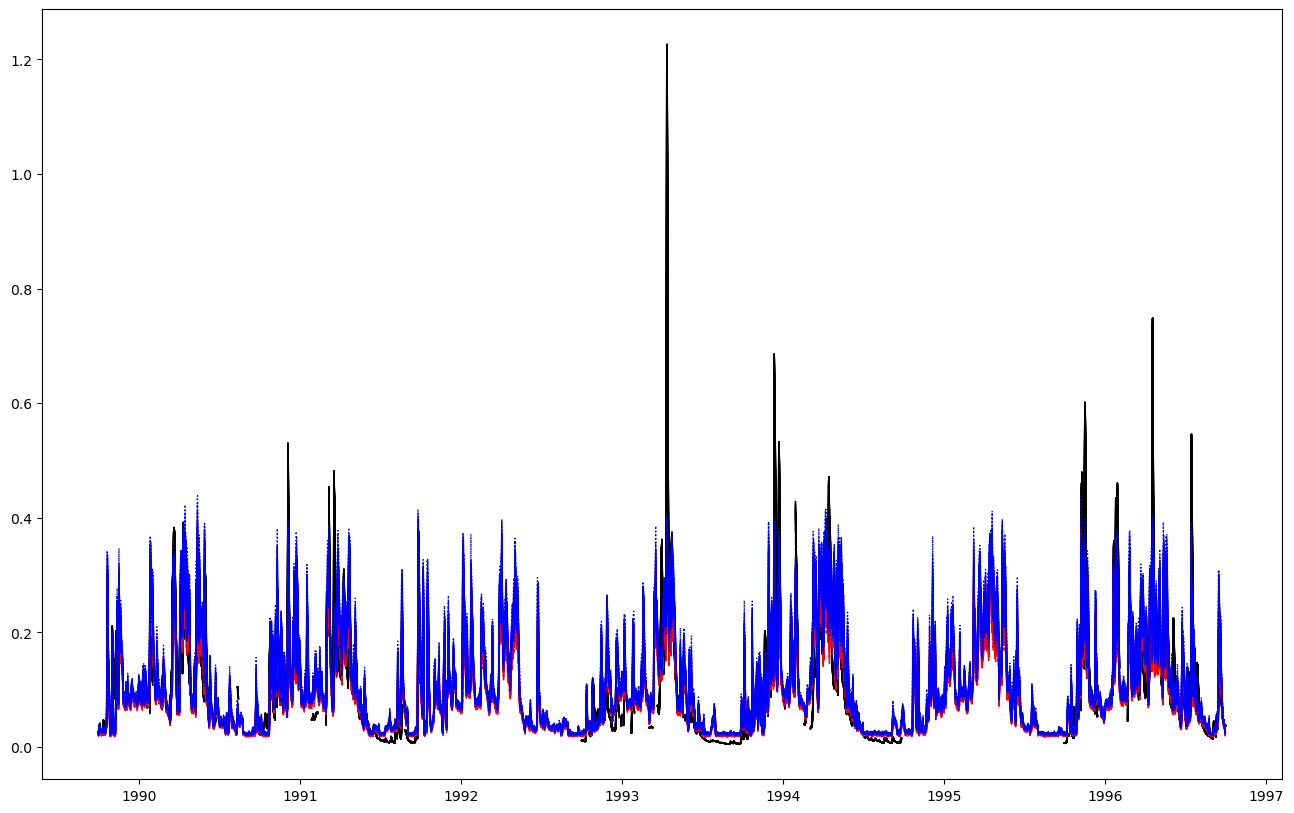

In [ ]:
basin_id = '01022500' # Your basin ID
freq = '1h'           # Your frequency key
target_variable = 'QObs(mm/h)' # Your target variable name

# --- 1. Extract Observations ---
# Added .squeeze() here to make qobs a 1D array (removing the time_step dimension)
qobs = results[basin_id][freq]['xr'][f'{target_variable}_obs'].squeeze()

# --- 2. Extract Simulated Output with Samples ---
# This variable contains 100 samples for each time step
qsim_with_samples = results[basin_id][freq]['xr'][f'{target_variable}_sim']

# --- 3. Calculate Quantiles from Samples ---
# Convert the xarray DataArray to a NumPy array for easier percentile calculation.
# The 'samples' dimension is the last one in (date, time_step, samples).
qsim_data = qsim_with_samples.values

# Calculate percentiles across the 'samples' dimension (axis=-1)
# np.nanpercentile handles potential NaN values if present.
median_sim_np = np.nanpercentile(qsim_data, 50, axis=-1)
q25_np = np.nanpercentile(qsim_data, 25, axis=-1)
q75_np = np.nanpercentile(qsim_data, 75, axis=-1)
lower_bound_90ci_np = np.nanpercentile(qsim_data, 5, axis=-1)
upper_bound_90ci_np = np.nanpercentile(qsim_data, 95, axis=-1)
mean_sim_np = np.nanmean(qsim_data, axis=-1)

# Convert the percentile arrays back to xarray DataArray to retain 'date' coordinates
# Now, qobs.copy() will create a 1D xarray.DataArray, and median_sim.squeeze() is also 1D,
# so their shapes will match.
median_sim_np = median_sim_np.flatten()
q25_np = q25_np.flatten()
q75_np = q75_np.flatten()
lower_bound_90ci_np = lower_bound_90ci_np.flatten()
upper_bound_90ci_np = upper_bound_90ci_np.flatten()
mean_sim_np = mean_sim_np.flatten()

# --- 4. Plotting with Seaborn for Uncertainty ---
fig, ax = plt.subplots(figsize=(16, 10))

# Plot observations
ax.plot(qobs['date'], qobs.values, color='black', label='Observations', linewidth=1)

# Plot median prediction
ax.plot(median_sim['date'], median_sim.values, color='red', linestyle='--', label='CMAL Median Prediction', linewidth=1)
ax.plot(mean_sim['date'], mean_sim.values, color='blue', linestyle=':', label='CMAL Mean Prediction', linewidth=1)

# Plot uncertainty bands using fill_between
# 90% Confidence Interval (between 5th and 95th percentiles)
ax.fill_between(
    lower_bound_90ci['date'].values,
    lower_bound_90ci.values,
    upper_bound_90ci.values,
    color='red',
    alpha=0.2, # Lighter transparency for the wider band
    label='CMAL 90% Uncertainty Interval'
)

# 50% Confidence Interval (between 25th and 75th percentiles)
ax.fill_between(
    q25['date'].values,
    q25.values,
    q75.values,
    color='red',
    alpha=0.4, # Darker transparency for the narrower band
    label='CMAL 50% Uncertainty Interval'
)

ax.set_ylabel(f"{target_variable} (mm/d)")
ax.set_xlabel("Date")
ax.set_title(f"Test period - CMAL Prediction with Uncertainty for Basin {basin_id}")
ax.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
# Calculate all metrics for the median prediction
values = metrics.calculate_all_metrics(qobs, mean_sim)

# Print the calculated metrics
print("\nMetrics for CMAL Median Prediction:")
for key, val in values.items():
    print(f"{key}: {val:.3f}")


Metrics for CMAL Median Prediction:
NSE: 0.029
MSE: 0.023
RMSE: 0.150
KGE: -0.078
Alpha-NSE: 0.175
Beta-KGE: 0.413
Beta-NSE: -0.401
Pearson-r: 0.629
FHV: -88.444
FMS: -39.521
FLV: -18.839
Peak-Timing: 0.167
Peak-MAPE: 87.573
